In [ ]:
# !pip install opencv-python

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
# import cv2
import itertools

import tensorflow as tf
import keras.layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout,Input,concatenate,GlobalAveragePooling2D
from keras.layers import ReLU, Add,BatchNormalization
from keras.models import Model, Sequential
# from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix,classification_report
import imageio
import matplotlib.image as img
import keras.backend as K

import os 
import pathlib 

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import imagenet_utils

In [21]:
# path=os.path.join(os.getcwd(),'Rice_Image_Dataset')
path = pathlib.Path("/kaggle/input/rice-image-dataset/Rice_Image_Dataset")

In [22]:
arborio = list(path.glob('Arborio/*'))[:1000]
basmati = list(path.glob('Basmati/*'))[:1000]
ipsala = list(path.glob('Ipsala/*'))[:1000]
jasmine = list(path.glob('Jasmine/*'))[:1000]
karacadag = list(path.glob('Karacadag/*'))[:1000]

In [23]:
data = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}
rice_labels= {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3:"Jasmine",
    4:"Karacadag"}

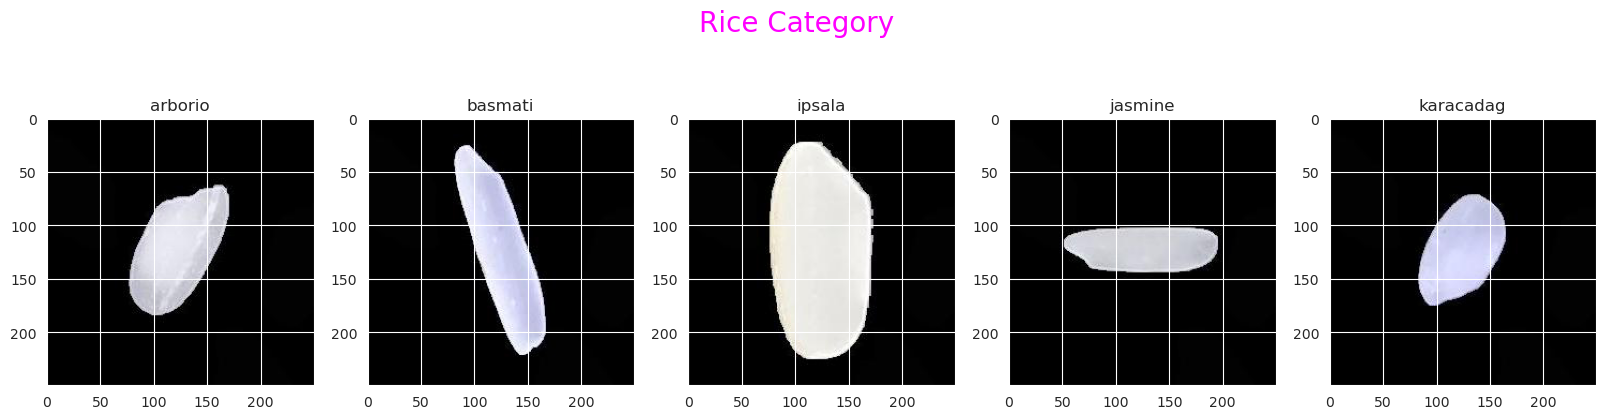

In [24]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category',color='magenta',fontsize=20)
arborio_img = img.imread(arborio[0])
basmati_img = img.imread(basmati[0])
ipsala_img = img.imread(ipsala[0])
jasmine_img = img.imread(jasmine[0])
karacadag_img = img.imread(karacadag[0])

for index,name in enumerate(list(data.keys())):
    ax[index].set_title(name)
ax[0].imshow(arborio_img)
ax[1].imshow(basmati_img)
ax[2].imshow(ipsala_img)
ax[3].imshow(jasmine_img)
ax[4].imshow(karacadag_img)


<matplotlib.image.AxesImage at 0x7df6d4085950>

In [25]:
train_datagen=ImageDataGenerator(rescale=1.0/255,validation_split=0.2)

train_data = train_datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  # Assuming labels are provided as integers
    shuffle=True,
    subset='training'
)

test_data = train_datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)


Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [7]:
def inception_block(input_shape, filter_1x1):
    
    # First branch
    branch_1_conv_1x1 = Conv2D(128, (1,1), padding='same', activation='relu')(input_shape)

    # Second branch
    branch_2_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_2_conv_3x3 = Conv2D(192, (3,3), padding='same', activation='relu')(branch_2_conv_1x1)
    branch_2_conv_1x1 = Conv2D(filter_1x1, (1,1), padding='same', activation='relu')(branch_2_conv_3x3)

    # Third branch
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_3_conv_5x5 = Conv2D(96, (5,5), padding='same', activation='relu')(branch_3_conv_1x1 )
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(branch_3_conv_5x5)

    branch_output = concatenate([branch_1_conv_1x1, branch_2_conv_1x1, branch_3_conv_1x1], axis=-1)
    
    return branch_output

In [8]:
input_shape = Input(shape=(128,128,3))
x = Conv2D(64, (7,7), activation='relu')(input_shape)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(32, (1,1), activation='relu')(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = GlobalAveragePooling2D()(x)
output = Dense(5, activation='softmax')(x)

In [9]:
model_1 = Model(inputs=input_shape, outputs=output)

In [10]:
model_1.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               

                                )]                                                                

                                                                                                  

 conv2d (Conv2D)                (None, 122, 122, 64  9472        ['input_1[0][0]']                

                                )                                                                 

                                                                                                  

 max_pooling2d (MaxPooling2D)   (None, 61, 61, 64)   0           ['conv2d[0][0]']                 

                                                                                   

In [11]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model_1.fit_generator(train_data, epochs=4, validation_data=test_data)

Epoch 1/4

1875/1875 [==============================] - 348s 176ms/step - loss: 0.2891 - accuracy: 0.8927 - val_loss: 0.1833 - val_accuracy: 0.9299

Epoch 2/4

1875/1875 [==============================] - 245s 131ms/step - loss: 0.0771 - accuracy: 0.9740 - val_loss: 0.0801 - val_accuracy: 0.9739

Epoch 3/4

1875/1875 [==============================] - 247s 131ms/step - loss: 0.0463 - accuracy: 0.9848 - val_loss: 0.0277 - val_accuracy: 0.9912

Epoch 4/4

1875/1875 [==============================] - 244s 130ms/step - loss: 0.0362 - accuracy: 0.9886 - val_loss: 0.0386 - val_accuracy: 0.9870


In [ ]:
test_loss, test_acc = model_1.evaluate_generator(test_data)
print("Test accuracy:", test_acc)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# **buliding the res_net model**

In [26]:
def res_block(input_shape, filters, strides=1):
    #
    shortcut = input_shape

    x = Conv2D(filters, (1,1), strides=1, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters*4, (1,1), padding='same')(x)
    x = BatchNormalization()(x)
    # Skip connection
    if strides !=1 or shortcut.shape[-1]!= filters*4:
        shortcut = Conv2D(filters*4, (1,1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

In [27]:
input_shape = Input(shape=(128,128,3))

# Build a simple ResNet with two residual blocks
x = Conv2D(64, (7,7), strides=2, padding='same')(input_shape)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(2,2)(x)
x = res_block(x, filters=64, strides=1)
x = res_block(x, filters=64, strides=1)
x = MaxPooling2D(2,2)(x)
x = res_block(x, filters=128, strides=1)
x = res_block(x, filters=128, strides=1)
x = MaxPooling2D(2,2)(x)
x = GlobalAveragePooling2D()(x)
output = Dense(5, activation='softmax')(x)

In [28]:
model_2 = Model(inputs=input_shape, outputs=output)

In [29]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 64, 64, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 64, 64, 64)  256         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [30]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model_2.fit_generator(train_data, epochs=4, validation_data=test_data)

Epoch 1/4
1875/1875 [==============================] - 504s 258ms/step - loss: 0.0755 - accuracy: 0.9742 - val_loss: 4.1985 - val_accuracy: 0.5875
Epoch 2/4
1875/1875 [==============================] - 216s 115ms/step - loss: 0.0321 - accuracy: 0.9890 - val_loss: 0.0852 - val_accuracy: 0.9737
Epoch 3/4
1875/1875 [==============================] - 192s 102ms/step - loss: 0.0287 - accuracy: 0.9903 - val_loss: 9.2460 - val_accuracy: 0.4391
Epoch 4/4
1875/1875 [==============================] - 191s 102ms/step - loss: 0.0245 - accuracy: 0.9918 - val_loss: 0.1639 - val_accuracy: 0.9416


In [32]:
test_loss, test_acc = model_2.evaluate_generator(test_data)
print("Test accuracy:", test_acc)

Test accuracy: 0.9416000247001648


<a id="import"></a>
# <p style="background:#ffb7ff url('pylogo.jpg') no-repeat; font-family:TimesNewRoman; font-size:100%; color:black; text-align:center; border-radius:20px 30px; width:80%; padding:30px">Phase E: Creating Simple Model</p>

In [ ]:
cnn.summary()

In [ ]:
cnn.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [ ]:
cnn.fit(train_data,epochs=2,validation_data=test_data,shuffle=True)

In [ ]:
def plot(c):
    plt.plot(c.history.history['accuracy'],marker='o',color='red',markersize=10)
    plt.plot(c.history.history['val_accuracy'],marker='*',color='green',markersize=10)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(c.history.history['loss'],marker='o',color='red',markersize=10)
    plt.plot(c.history.history['val_loss'],marker='*',color='green',markersize=10)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()


In [ ]:
plot(cnn)

* __In the first epoch, **Accuracy** of **Train** is **0.955** and for **Test** is upper **0.98** . that shows us we should increase the value of **epoch**. On the other hand in the second epoch, the value of **test_Accuracy** is close to the **Train_Accurcay**
* __Beside, from the second plot we can understand this issue and finally we decide that increase the number of **Epochs**

<a id="import"></a>
# <p style="background:#ffbbaa url('pylogo.jpg') no-repeat; font-family:TimesNewRoman; font-size:100%; color:black; text-align:center; border-radius:20px 30px; width:80%; padding:30px">Phase E-1: Creating Second Model </p>

* __Here, we increase the number of **epochs** to have higher scores, but we can stop the process of running the model by **keras.callbacks.EarlyStopping**

* __A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

##### You can use callbacks to:

* __Write TensorBoard logs after every batch of training to monitor your metrics
* __Periodically save your model to disk
* __Do early stopping
* __Get a view on internal states and statistics of a model during training
* __...and more


* __we use **EarlyStopping** in our model for stopping the running after 10 times. You can assign the smaller value to this hyperparameter, but we want to run more for better showing.

In [ ]:
cnn2=keras.models.Sequential()
cnn2.add(keras.layers.Conv2D(filters=32,kernel_size=3,
                            padding='valid',activation='relu',input_shape=(224,224,3)))
cnn2.add(keras.layers.MaxPool2D(pool_size=2,strides=2))
cnn2.add(keras.layers.Flatten())
cnn2.add(keras.layers.Dense(45,activation='relu'))
cnn2.add(keras.layers.Dense(15,activation='relu'))
cnn2.add(keras.layers.Dropout(rate= 0.1, seed= 100))
cnn2.add(keras.layers.Dense(units=5,activation='sigmoid'))

In [ ]:
cnn2.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [ ]:
cnn2.fit(train_data,epochs=40,validation_data=test_data,shuffle=True,
         callbacks=keras.callbacks.EarlyStopping(monitor="val_loss",patience=10))

In [ ]:
plot(cnn2)

* __After the model training, seeing the above chart, we conclude that the best **epoch** is **six** for our model, because in this amount, train and test are very close to each other and we have received a good score for the two.

In [ ]:
y_pred = cnn2.predict(test_data)
main_y_pred = np.argmax(y_pred, axis=1)


In [ ]:
test_steps_per_epoch = np.math.ceil(test_data.samples / test_data.batch_size)

predictions = cnn2.predict_generator(test_data, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys()) 
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

In [ ]:
cm = confusion_matrix(test_data.classes, predicted_classes)
d1=test_data.class_indices
classes = list(d1.keys())
cmap= plt.cm.YlGnBu
plt.figure(figsize= (6, 6))
plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
plt.title('Confusion Matrix')
plt.colorbar(shrink=True)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 90)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'aqua' if cm[i, j] > thresh else 'red')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
cm



In [ ]:

train_score = cnn2.evaluate(train_data, verbose= 1)
test_score = cnn2.evaluate(test_data, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('*****************************')
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

* __Well, in according to the above plot and **Confusion_Matirx** results, we found that our model is good because:

* __the **Accuracy** of **Train** is **0.999** and the **loss** value of it is **0.001** .

* __the **Accuracy** of **Test** is **0.99** and the **loss** value of it is **0.064** and these values are great

* __So that we dont need use **ResNet50** and the other well-known Architecture for this dataset.

### Best Regards!